# CMB lensing measurement of MaDCoWS masses with ACT

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from colossus.cosmology import cosmology as colossus_cosmology
import colossus.halo.concentration as concentration
import os
from matplotlib import pyplot as plt, ticker
import numpy as np
import pyccl as ccl
from scipy.integrate import trapz
from scipy import stats

These modules below must be downloaded manually

In [2]:
# https://github.com/cristobal-sifon/profiley
from profiley.nfw import NFW
from profiley.filtering import Filter
from profiley.helpers import lss

# https://github.com/cristobal-sifon/stattools
from stattools import pte as PTE

# https://github.com/cristobal-sifon/plottools
from plottools.plotutils import colorscale, update_rcParams
update_rcParams()

# Notes for reproducing the data reduction

In this project we used ``profiley v1.1.0`` to fit reduced lensing measurements obtained from running scripts in github.com/simonsobs/cmbhalolensing on ACT and Planck data. 

For future reproducibility, we provide details on the scripts from cmbhalolensing that were run to produce the reduced data. Note that while simonsobs/cmbhalolensing is public code, the ACT data products required for it have not yet been publicly released.

cmbhalolensing branch and commit hash: master, 903932d4320bda9cc492a55635ed3187626218a5

symlens branch and commit hash: master, 599d834eacfffa91261ee92d0a6dfd7fedcabb36 (v0.3.3)

orphics branch and commit hash: master, 64598101b00fbe4941dcc4ce71a0dee604b2f846

pixell branch and commit hash: fix_thumbnails, 307a530b38e5344649902629fe2ee5352e645591

(symlens, pixell and orphics are key dependencies of cmbhalolensing)

### Mean-field catalog generation
```
python mapcat.py madcows_photz
python randcat.py madcows_photz 200
```

### Lens
```
OMP_NUM_THREADS=10 mpirun -np 8 python stack.py mpz_lam20_night madcows_photz -o --snmin 20 --night-only
```

### Lens meanfield
```
mpi_niagara 64 "python stack.py mpz_night_mf_largen madcows_photz -o --is-meanfield --night-only" -t 20 --walltime "01:00:00"
```

### Lens post-processing
```
python post.py mpz_lam20_night_v3 mpz_lam20_night_madcows_photz_plmin_200_plmax_2000_almin_200_almax_6000_klmin_200_klmax_5000_lxcut_2_lycut_2_swidth_128.00_tapper_12.00_padper_3.00_night_act_planck_s18 mpz_night_mf_largen_madcows_photz_plmin_200_plmax_2000_almin_200_almax_6000_klmin_200_klmax_5000_lxcut_2_lycut_2_swidth_128.00_tapper_12.00_padper_3.00_night_act_planck_s18_meanfield 
```

### Curl
```
OMP_NUM_THREADS=10 mpirun -np 8 python stack.py mpz_lam20_night_curl madcows_photz -o --snmin 20 --night-only --curl
```

### Curl meanfield
```
mpi_niagara 64 "python stack.py mpz_night_curl_mf_largen madcows_photz -o --is-meanfield --night-only --curl" -t 20 --walltime "01:00:00"
```

### Curl post-processing
```
python post.py mpz_lam20_night_v3_curl mpz_lam20_night_curl_madcows_photz_plmin_200_plmax_2000_almin_200_almax_6000_klmin_200_klmax_5000_lxcut_2_lycut_2_swidth_128.00_tapper_12.00_padper_3.00_night_act_planck_s18_curl mpz_night_curl_mf_largen_madcows_photz_plmin_200_plmax_2000_almin_200_almax_6000_klmin_200_klmax_5000_lxcut_2_lycut_2_swidth_128.00_tapper_12.00_padper_3.00_night_act_planck_s18_curl_meanfield 
```

### PTE and SNR
```
python pte.py mpz_lam20_night_v3
```

# Load ACT x MaDCoWS catalog and plot redshift and richness distributions

This file contains the redshifts, weights, and richnesses of ACT x MaDCoWS clusters

In [3]:
wisename = 'mpz_lam20_night_v3'
cwisename = 'mpz_lam20_night_v3'

Redshift distribution

z_min = 0.75, z_max = 1.75
z_mean = 1.08, z_med = 1.06
16-84 percentile redshift range: [0.93 1.26]


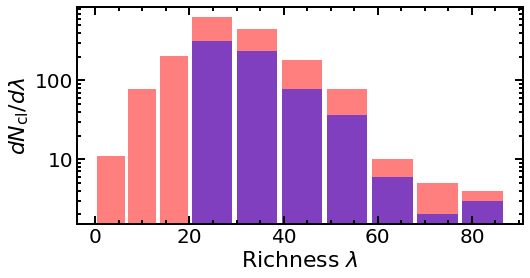

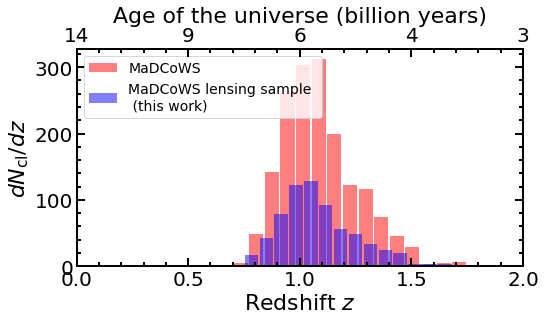

In [5]:
long_range = False # whether to extend the z-range to CMB source redshift
lookback = False # whether to plot lookback time
rwidth = 0.9

# The clusters used in this analysis
lams, _, zcl = np.loadtxt(f'../data/{wisename}/{wisename}_catalog_data.txt',unpack=True)
# The full set of MaDCOWs clusters
fzcl, flams = np.genfromtxt('../data/madcows_cleaned.txt',usecols=[6,8],unpack=True,delimiter=',')
flams = flams[~np.isnan(fzcl)]
fzcl = fzcl[~np.isnan(fzcl)]

print(f"z_min = {zcl.min()}, z_max = {zcl.max()}")
print(f"z_mean = {zcl.mean():.2f}, z_med = {np.median(zcl)}")
print(f"16-84 percentile redshift range: {np.percentile(zcl, [16,84])}")

def hist(x,fx,xlabel,ylabel,xscale,yscale,xmin,xmax,fname,loc):
    # Plot histogram for richness or redshift
    if 'Richness' in xlabel:
        fig, ax = plt.subplots(figsize=(8,4))
        fbins = np.linspace(20,fx[np.isfinite(fx)].max(),8)
        n_bins = np.append(np.linspace(0,20,4) , fbins)
    else:
        fig, ax = plt.subplots(figsize=(8,4))
        n_bins = 15
    n, bins, patches = ax.hist(fx, n_bins, #histtype='bar',
                               cumulative=False, lw=2,ls='--',label='MaDCoWS',color='red',alpha=0.5,rwidth=rwidth) # ,color='k'
    if 'Richness' in xlabel:
        n_bins = fbins
    else:
        n_bins = 15
    n, bins, patches = ax.hist(x, n_bins, #histtype='bar',
                               cumulative=False, lw=2,label='MaDCoWS lensing sample \n (this work)',color='blue',alpha=0.5,rwidth=rwidth) # ,color='k'
    if loc is not None: ax.legend(loc=loc,frameon = 1,prop={'size':14})
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlim(xmin,xmax)

    if not('Richness' in xlabel):
        ax2 = ax.twiny()
        ax2.set_xscale(xscale)
        ax2.set_xlim(ax.get_xlim())

        def tick_function(X):

            if long_range:
                V = (cosmo.age(X)*1e9).value
                out = ["%.0e" % z for z in V]
            else:
                if lookback:
                    V = 13.7 - (cosmo.age(X)).value
                else:
                    V = (cosmo.age(X)).value
                out = ["%.0f" % np.rint(z) for z in V]
            return out

        if long_range:
            ax.axvline(x=1100.,ls='--')
            lzs,lws = np.loadtxt("../data/lens_window.csv",unpack=True,delimiter=',')
            ax.plot(lzs,lws*100)
            zticks = np.asarray([0.1,1,10,100,1000])
        else:
            zticks = np.asarray([0.,0.5,1,1.5,2])
        
        ax2.set_xticks(zticks)
        cosmo = FlatLambdaCDM(H0=67.7 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.307)
        
        ax2.set_xticklabels(tick_function(zticks))

        if long_range:
            assert not(lookback)
            ax2.set_xlabel(r"Age of the universe (years)")
        else:
            if lookback:
                ax2.set_xlabel(r"Lookback time (billion years)")
            else:
                ax2.set_xlabel(r"Age of the universe (billion years)")
    
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    plt.savefig(fname,bbox_inches='tight')


hist(lams,flams,'Richness $\\lambda$','$dN_{\\rm cl}/d\\lambda$','linear','log',None,None,'../lamhist.pdf',None)
if long_range:
    hist(zcl,fzcl,'Redshift $z$','$dN_{\\rm cl}/dz$','log','linear',0.1,2000,'../zhist.pdf','upper left')
else:
    hist(zcl,fzcl,'Redshift $z$','$dN_{\\rm cl}/dz$','linear','linear',0.0,2,'../zhist.pdf','upper left')

This is Figure 1 of the paper.

# Plot the 2d stacked image

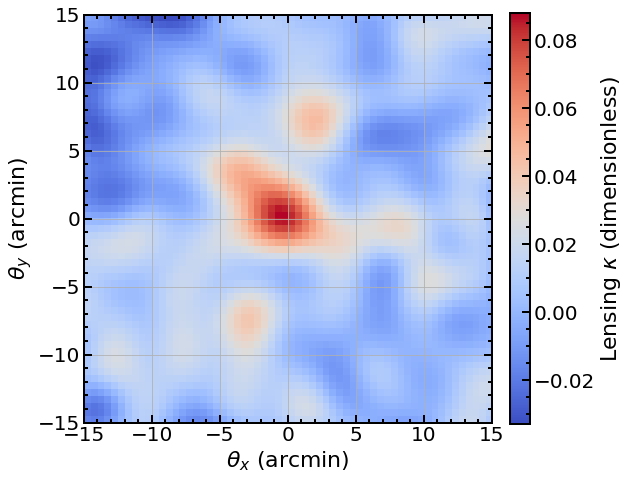

In [6]:
from pixell import enmap,utils as putils


def crop_center(img,cropy,cropx=None,sel=False):
    cropx = cropy if cropx is None else cropx
    y,x = img.shape[-2:]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    selection = np.s_[...,starty:starty+cropy,startx:startx+cropx]
    if sel:
        ret = selection
    else:
        ret = img[selection]
    return ret

# The pixel width in arcminutes
pix_width_arcmin = 0.5
# The cropped width in arcminutes
cwidth = 30.
# Load the filtered mean-field subtracted 2d stack
stamp = enmap.read_map(f"../data/{wisename}/{wisename}_sm_opt_weighted_mfsub.fits")
crop = int(cwidth / pix_width_arcmin)
# Percentage of tapering and padding applied during the analysis
tap_per = 12.0
pad_per = 3.0

# Trim and crop
trimy = int((tap_per+pad_per)/100. * stamp.shape[0])
trimx = int((tap_per+pad_per)/100. * stamp.shape[1])
if trimy>0 and trimx>0:
    tmap = stamp[trimy:-trimy,trimx:-trimx]
else:
    tmap = stamp
tmap = crop_center(tmap,crop)
zfact = tmap.shape[0]*1./stamp.shape[0]
arc_width = tmap.extent()[0]/putils.arcmin  


extent = [-arc_width/2.,arc_width/2.,-arc_width/2.,arc_width/2.]

fig, ax = plt.subplots(figsize=(8,8))
img = ax.imshow(tmap,interpolation="none",cmap='coolwarm',extent=extent)
ax.grid()
xlabel='$\\theta_x$ (arcmin)' ; ylabel='$\\theta_y$ (arcmin)'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xticks(np.linspace(round(-arc_width/2.), round(arc_width/2.), 7))
ax.set_yticks(np.linspace(round(-arc_width/2.), round(arc_width/2.), 7))

cbar = fig.colorbar(img,fraction=0.046, pad=0.04)
cbar.set_label(label='Lensing $\\kappa$ (dimensionless)')

fig.savefig('../fig2.pdf',bbox_inches='tight')



This is Figure 2 in the paper.

# Load the 1d reduced data and plot the correlation matrix

Load angular bins (in arcmin)

In [7]:
theta_bins = np.loadtxt(f'../data/{wisename}/{wisename}_bin_edges.txt')
theta_centers = (theta_bins[:-1]+theta_bins[1:]) / 2
theta_bins

array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5])

Load convergence profile and covariance matrix

In [8]:
x_theta, kappa_measured = np.loadtxt(f'../data/{wisename}/{wisename}_profile.txt', unpack=True)
kappa_cov = np.loadtxt(f'../data/{wisename}/{wisename}_covmat.txt')

Although there are nine data points in the files, we work with the first five datapoints only to ensure a well-behaved inverse covariance matrix. That is controlled by the parameter ``max_bin``:

In [9]:
max_bin = 5
if max_bin is None:
    max_bin = x_theta.size
    
kappa_err = np.diag(kappa_cov)**0.5

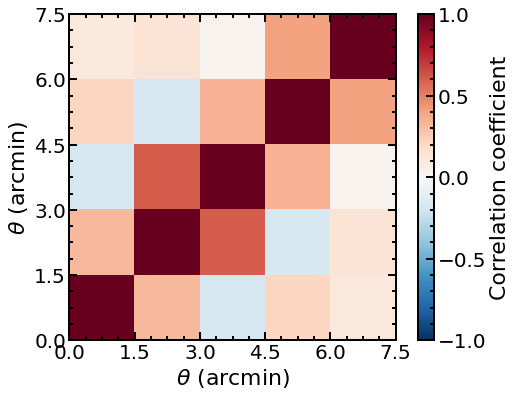

In [10]:
kappa_corr = np.array([[kappa_cov[i,j]/(kappa_cov[i,i]*kappa_cov[j,j])**0.5
                        for j in range(max_bin)] for i in range(max_bin)])
fig, ax = plt.subplots(figsize=(8,6))
extent = (theta_bins[0], theta_bins[max_bin], theta_bins[0], theta_bins[max_bin])
im = ax.imshow(kappa_corr, origin='lower', extent=extent, cmap='RdBu_r', vmin=-1, vmax=1)
cbar = plt.colorbar(im, ax=ax, fraction=0.045, label='Correlation coefficient')
cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_xlabel(r'$\theta$ (arcmin)')
ax.set_ylabel(r'$\theta$ (arcmin)')
ax.set_xticks(theta_bins[:max_bin+1])
ax.set_yticks(theta_bins[:max_bin+1])
fig.savefig('../fig3b.pdf',bbox_inches='tight')

This is the bottom panel of Fig 3.

# Proceed to fitting the 1d data

The inverse covariance matrix

In [11]:
Cinv = np.linalg.inv(kappa_cov[:max_bin,:max_bin])
# the dot product should give an identity
assert np.allclose(kappa_cov[:max_bin,:max_bin]@Cinv, np.eye(max_bin))

Let's also load curl measurements

In [12]:
xcurl, curl = np.loadtxt(f'../data/{cwisename}_curl/{cwisename}_curl_profile.txt', unpack=True)[:,:max_bin]
curl_cov = np.loadtxt(f'../data/{cwisename}_curl/{cwisename}_curl_covmat.txt')[:max_bin,:max_bin]
curl_err = np.diag(curl_cov)**0.5

We now load the Fourier-space filter into ``profiley``.

In [13]:
kmask_file = f'../data/{wisename}/{wisename}_kmask.fits'
filt = Filter(kmask_file)

The ``Filter`` object relies on the ``pixell`` library (https://github.com/simonsobs/pixell). The version implemented in ``profiley v1.1.0`` corresponds to the ``pixell`` commit hash ``cecff8e`` from 2020-09-03.

We need to sample the profile quite finely in order for the filtering to be accurate.

In [14]:
theta_bins_fine = np.linspace(0, 50, 1001) * u.arcmin
theta_fine = (theta_bins_fine[:-1]+theta_bins_fine[1:]) / 2

# Helpers

In [15]:
def N_expected():
    """Expected number of observed clusters given the halo model"""
    int_obs_norm = np.array([trapz(obs * P_lnobs_i * S_lnobs, lnobs)
                             for P_lnobs_i in P_lnobs])
    int_m_norm = trapz(dndlnm*int_obs_norm, lnm)
    return trapz(Ncl_z * int_m_norm, z[:,0])

def mean_signal(X):
    """Expected mean signal given the halo model"""
    if len(X.shape) == 3:
        X = np.expand_dims(X, -1)
    int_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs * X, lnobs)
                        for P_lnobs_i in P_lnobs])
    int_m = trapz(dndlnm*int_obs, lnm)
    norm = N_expected()
    return trapz(Ncl_z * int_m, z[:,0]) / norm[:,None]

In [16]:
def bestfit(X, chi2, label=None, print_norm=1, print_snr=False):
    """Extract the best-fit value and |Delta(chi2)|=1 uncertatinties

    Parameters
    ----------
    X : ndarray, shape (N,)
        parameter of interest
    chi2 : ndarray, shape (N,)
        chi2 for each parameter in X
    label : str, optional
        name of parameter X, for printing purposes
    print_norm : float, optional
        value with which to normalize X when printing (used to
        print mass in units of 1e14 Msun)
    print_snr : bool, optional
        whether to print the resulting SNR, i.e., the distance
        from the best-fit value to zero in units of the lower
        uncertainty.

    Returns
    -------
    best, (err_lo,err_hi) : floats
        best-fit value and 1-sigma uncertainties
    """
    chi2_diff = chi2 - chi2.min()
    jbest = np.argmin(chi2)
    # these account for the possibility that the best-fit
    # value is at one of the edges
    j1 = np.argmin(np.abs(chi2_diff[:jbest]-1)) if (jbest > 0) else 0
    j2 = jbest + np.argmin(np.abs(chi2_diff[jbest:]-1)) \
        if (jbest < chi2.size-1) else chi2.size-1

    best = X[jbest]
    err_lo = best - X[j2]
    err_hi = X[j1] - best
    # some parameters may be in decreasing order
    if err_lo < 0:
        err_lo, err_hi = -err_hi, -err_lo
    info = f'{best/print_norm:.1f} -{err_lo/print_norm:.1f} +{err_hi/print_norm:.1f}'
    if print_snr:
        info = f'{info} (SNR={best/err_lo:.1f})'
    if label:
        info = f'{label}: {info}'
    print(info)
    return best, (err_lo, err_hi)

This function allows easy visualization of the intermediate steps

In [17]:
def plot_profile_mz(R, profile, z, mx=None, z0=1, m0=1e14, xscale='log', yscale='log',
                    xlabel='', ylabel='', output='', close=False, fs=14, figaxes=None):
    """A helper function to plot a few sample profiles"""
    z = np.squeeze(z)
    if len(R.shape) == 1:
        R = np.array([R for i in range(z.size)])
    if mx is None:
        lnm = np.log(m)
    else:
        lnm = np.log(mx)
    logm = np.log10(np.exp(lnm))
    idx_z = np.argmin(np.abs(z-z0))
    idx_m = np.argmin(np.abs(lnm-np.log(m0)))
    if figaxes is None:
        fig, axes = plt.subplots(figsize=(14,5), ncols=2)
    else:
        fig, axes = figaxes
    # varying redshift
    axes[0].set_title('log10(m)={0:.2f}'.format(logm[idx_m]), fontsize=fs)
    colors, cmap = colorscale(z)
    for i in range(z.size):
        axes[0].plot(R[i], profile[i,idx_m], color=colors[i])
    if figaxes is None:
        plt.colorbar(cmap, label='Redshift', ax=axes[0])
    # varying mass
    axes[1].set_title('z={0:.2f}'.format(z[idx_z]), fontsize=fs)
    colors, cmap = colorscale(logm)
    for i in range(lnm.size):
        axes[1].plot(R[idx_z], profile[idx_z,i], color=colors[i])
    if figaxes is None:
        plt.colorbar(cmap, label='log10 m', ax=axes[1])
    for ax in axes:
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
    if output:
        savefig(output, fig=fig, close=close)
    else:
        fig.tight_layout()
    return fig, axes

# Cosmology

In [18]:
delta = 500
ref_density = 'critical'

$H_0$ and $\Omega_\mathrm{m}$ same as González et al. (2019); others are Planck 2018 best-fit values.

In [19]:
H0 = 67.7
Omega_m = 0.307
Omega_b = 0.0224/(H0/100)**2
Omega_c = Omega_m - Omega_b
ns = 0.965
sigma8 = 0.81
As = 2.1e-9
Tcmb = 2.725

``astropy`` (for distances)

In [20]:
cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m, Ob0=Omega_b, Tcmb0=Tcmb)

``colossus`` (for mass-concentration relation)

In [21]:
params = dict(Om0=Omega_m, H0=H0, ns=ns, sigma8=sigma8, Ob0=Omega_b)
colossus_cosmology.setCosmology('cosmo', params)

``CCL`` (for halo mass function, halo bias and matter power spectrum). Note that we also define the mass to be used in ``CCL`` routines here.

In [22]:
cclcosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=H0/100, A_s=As, n_s=ns)
mdef = ccl.halos.MassDef(delta, ref_density)

Source redshift for lensing convergence

In [23]:
zs = 1100

# Halo model

We start by calculating the 1-halo and 2-halo convergence terms over a grid in mass and redshift. So let's first define this grid.

In [24]:
zbins = np.arange(0.65, 1.86, 0.1)
z = (zbins[1:]+zbins[:-1]) / 2
# extra dimension for use later
z = z[:,None]

In [25]:
m = 10**np.arange(12.7, 15.71, 0.1)
logm = np.log10(m)
lnm = np.log(m)

## 1-halo term

In order to calculate the 1-halo term we first choose a mass-concentration relation:

In [26]:
%%time
c_label = 'diemer19'
fc = concentration.concentration
c = np.array([fc(m, f'{delta}{ref_density[0]}', zi, model=c_label)
              for zi in z[:,0]])

CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.68 s


and we need the projected separation, which we choose to define in physical coordinates:

In [27]:
Rfine_1h = (theta_fine * cosmo.kpc_proper_per_arcmin(z)).to(u.Mpc).value.T
Rfine_1h.shape

(1000, 12)

We can now define our NFW profile objects and get their convergence, as simple as

In [28]:
%%time
nfw = NFW(m, c, z, cosmo=cosmo, overdensity=delta, background=ref_density[0], frame='physical')
kappa_1h = np.transpose(nfw.convergence(Rfine_1h[:,:,None], zs), axes=(1,2,0))
kappa_1h.shape

CPU times: user 13.1 ms, sys: 8.05 ms, total: 21.1 ms
Wall time: 20.6 ms


(12, 31, 1000)

That's it! Now all we need to do is filter them.

In [29]:
%%time
kappa_1h_filt = []
for zi, kappa_z in zip(z, kappa_1h):
    kappa_1h_mz_filt = np.array(
        [filt.filter(theta_fine, kappa_z_i, theta_bins, units='arcmin')[1]
         for kappa_z_i in kappa_z])
    kappa_1h_filt.append(kappa_1h_mz_filt)
kappa_1h_filt = np.transpose(kappa_1h_filt, axes=(2,0,1))
print(kappa_1h_filt.shape)

(9, 12, 31)
CPU times: user 2.15 s, sys: 2.36 ms, total: 2.16 s
Wall time: 2.16 s


## 2-halo

For the two halo term we proceed as outlined in Appendix B, but projecting the correlation function into a surface density is by far the most time-consuming step in this procedure. Therefore, we provide a separate script (`sigma_twohalo.py`) which speeds up this calculation by using multiprocessing, which cannot be used within jupyter notebooks. The file has been stored, and can be loaded, using helper functions provided with ``profiley``.

Here we will only use the first element returned by ``lss.load_profile`` (namely, the profiles themselves). See the help page for more details.

In [30]:
sigma_2h = lss.load_profiles('sigma_2h.txt')[0]
sigma_2h.shape

(12, 31, 1000)

And the convergence is just $\kappa=\Sigma/\Sigma_\mathrm{cr}$. The two-halo term calculations are performed in comoving coordinates, let's set our NFW profiles to work in comoving coordinates now. For our purposes all this really means is that the critical surface density gets rescaled by a factor $(1+z)^{-2}$.

In [31]:
nfw.frame = 'comoving'

In [32]:
kappa_2h = sigma_2h / nfw.sigma_crit(zs=1100)[:,:,None]
kappa_2h.shape

(12, 31, 1000)

Note that we used the same angular separation sampling to calculate both the 1-halo and 2-halo terms. Let's see how the unfiltered profiles look, for a sample of masses and redshifts.

(<Figure size 1008x360 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ce860c640>,
       dtype=object))

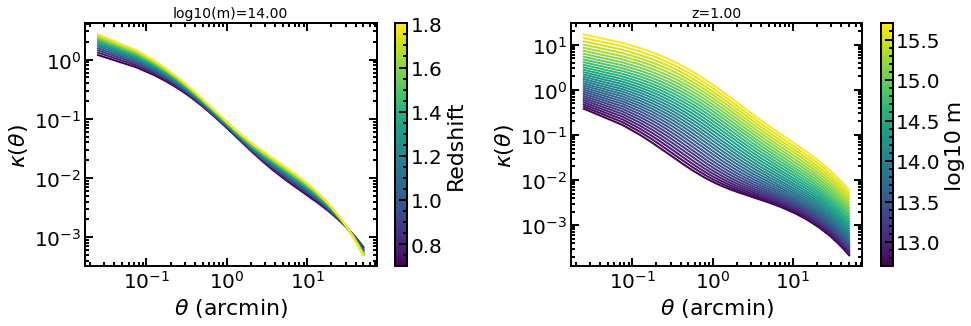

In [33]:
plot_profile_mz(theta_fine.T, kappa_1h+kappa_2h, z, xlabel=r'$\theta$ (arcmin)', ylabel=r'$\kappa(\theta)$')

And we now filter the 2-halo term as well:

In [34]:
%%time
kappa_2h_filt = np.transpose(
    [[filt.filter(theta_fine, kappa_2h[i,j], theta_bins, units='arcmin')[1]
      for j in range(m.size)] for i in range(z.size)],
    axes=(2,0,1))
print(kappa_2h_filt.shape)

(9, 12, 31)
CPU times: user 2.18 s, sys: 637 ms, total: 2.81 s
Wall time: 2.81 s


Our total signal is then the sum of the 1h and 2h terms.

In [35]:
kappa_filt = kappa_1h_filt + kappa_2h_filt

## Halo model averaging

We incorporate the observable by defining a mass-observable relation, $\ln\lambda=\alpha\cdot m+\beta$, with a scatter fixed to $\sigma=0.5$.

In [36]:
sigma = 0.5

We fix $\alpha=1$, meaning we assume a linear relation between mass and richness.

In [37]:
alpha = 1

so that $\beta$ is our only free parameter. The following range in $\beta$ is sufficient.

In [38]:
beta = np.arange(20, -5, -0.02)

In [39]:
kappa_theta = kappa_filt
kappa_theta_1h = kappa_1h_filt
kappa_theta_2h = kappa_2h_filt

### Conditional probability of richness given mass and redshift $P(\ln \lambda | \ln m,z)$

Let us first define the observable range

In [40]:
lnobs = np.linspace(np.log(10), np.log(100), 120)
obs = np.exp(lnobs)

In [41]:
lnobs_given_lnm = np.expand_dims(beta[:,None,None] + alpha*(lnm-np.log(1e14)), -1)
P_lnobs = np.exp(-(lnobs-lnobs_given_lnm)**2/(2*sigma**2)) / ((2*np.pi)**0.5*sigma)

### Selection function $S(\lambda,z)$


In [42]:
obs_min = 20
lnobs_min = np.log(obs_min)

below_thresh = (lnobs < lnobs_min)
S_lnobs = np.ones(lnobs.size)
S_lnobs[below_thresh] = 0

### Integrate observable

Let's call this $F$:

$F(m,z) = \int d\lambda \mathcal{P}(\ln \lambda | \ln m,z)\mathcal{S}(\lambda,z) \, \hat\kappa(\theta|m,z)$

we also calculate here the equivalent integral required for the normalization (same, without the $\kappa$ factor).

In [43]:
%%time
# so as not to add more dimensions when we re-run this cell
if len(kappa_filt.shape) == 3:
    kappa_filt = np.expand_dims(kappa_filt, -1)
# it may run out of memory if this is done fully vectorized
int_obs = np.array(
    [trapz(P_lnobs_i * S_lnobs * kappa_filt, obs) for P_lnobs_i in P_lnobs])
int_obs_norm = np.array(
    [trapz(P_lnobs_i * S_lnobs, obs) for P_lnobs_i in P_lnobs])

CPU times: user 2.39 s, sys: 1.75 s, total: 4.14 s
Wall time: 4.14 s


## Average over mass function at fixed redshift

Let's call this $G$:

$G(z) = \int dm \frac{d^2n}{dm\,dz} F(m,z)$

We start by calculating the halo mass function using `CCL`:

In [44]:
hmf_ccl_def = ccl.halos.MassFuncTinker10(cclcosmo, mass_def=mdef)
dndlog10m = np.array([hmf_ccl_def.get_mass_function(cclcosmo, m, 1/(1+zi))
                      for zi in z[:,0]])
dndlnm = np.log(10) * dndlog10m

In [45]:
%%time
int_m = trapz(dndlnm*int_obs, lnm)
int_m_norm = trapz(dndlnm*int_obs_norm, lnm)

CPU times: user 32.2 ms, sys: 12 ms, total: 44.2 ms
Wall time: 43.3 ms


## Average over redshift

Finally, we average over redshift to produce the predicted mean signal for each value of $\beta$:

$\langle \hat\kappa \rangle = \frac1{\bar N}\int dz N_\mathrm{cl}G(z)$,

where $N_\mathrm{cl}$ is the histogram of cluster redshifts

In [46]:
Ncl_z = np.histogram(zcl, zbins)[0]

In [47]:
kappa_sum = trapz(Ncl_z * int_m, z[:,0])
norm = trapz(Ncl_z * int_m_norm, z[:,0])
kappa_avg = kappa_sum / norm[:,None]

## Mean mass

We calculate the mean mass following the same procedure above:

In [48]:
# %%time
mint_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs * m[:,None], lnobs) for P_lnobs_i in P_lnobs])
mint_m = trapz(dndlnm*mint_obs, lnm)
m_avg = trapz(Ncl_z * mint_m, z[:,0]) / norm

and the concentration:

In [49]:
cint_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs * c[:,:,None], lnobs) for P_lnobs_i in P_lnobs])
cint_m = trapz(dndlnm*cint_obs, lnm)
c_avg = trapz(Ncl_z * cint_m, z[:,0]) / norm

And finally the richness:

In [50]:
oint_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs * obs, lnobs) for P_lnobs_i in P_lnobs])
oint_m = trapz(dndlnm*oint_obs, lnm)
o_avg = trapz(Ncl_z * oint_m, z[:,0]) / norm

## Calculate $\chi^2$

In [51]:
diff = (kappa_avg[:,:max_bin] - kappa_measured[:max_bin])
diff.shape

(1250, 5)

That's 1,250 values of $\beta$ times 5 data points. The $\chi^2$:

In [52]:
chi2 = np.array([np.dot(d, np.dot(Cinv, d)) for d in diff])
jbest = np.argmin(chi2)
dchi2 = chi2 - chi2.min()
chi2_model = chi2.min()
print(f'chi2_model = {chi2_model:.1f}')

chi2_model = 1.4


Draw samples to calculate PTE. 1 million samples is enough for convergence.

In [53]:
%%time
like = np.exp(-chi2) # not normalized
sample_idx = np.random.choice(chi2.size, size=1000000, p=like/like.sum())
kappa_mc = kappa_avg[sample_idx,:max_bin]
residuals_mc = kappa_mc - kappa_measured[:max_bin]
chi2_mc = np.array([np.dot(i, np.dot(Cinv, i)) for i in residuals_mc])
residuals_expected_mc = stats.multivariate_normal.rvs(cov=kappa_cov[:max_bin,:max_bin], size=sample_idx.size)
chi2_expected_mc = np.array([np.dot(i, np.dot(Cinv, i)) for i in residuals_expected_mc])
pte = (chi2_expected_mc > chi2.min()).sum() / chi2_expected_mc.size
print(f'PTE = {pte:.3f}')

PTE = 0.930
CPU times: user 4.36 s, sys: 77.8 ms, total: 4.44 s
Wall time: 3.95 s


# Plot!

In [54]:
%%time
kappa_theta_1h_avg = mean_signal(kappa_1h_filt)
kappa_theta_2h_avg = mean_signal(kappa_2h_filt)

CPU times: user 4.69 s, sys: 67.1 ms, total: 4.75 s
Wall time: 4.75 s


We re-filter the profiles using finer bins for the plot

In [55]:
%%time
finestep = 0.5
theta_bins_fine = np.arange(x_theta[0]-finestep/2, x_theta[max_bin-1]+finestep, finestep)
x_theta_fine = (theta_bins_fine[:-1]+theta_bins_fine[1:]) / 2
if np.iterable(z):
    kappa_1h_filt_fine = np.transpose(
        [[filt.filter(theta_fine, kappa_1h[i,j], theta_bins_fine, units='arcmin')[1]
          for j in range(m.size)] for i in range(z.size)],
        axes=(2,0,1))
    kappa_2h_filt_fine = np.transpose(
        [[filt.filter(theta_fine, kappa_2h[i,j], theta_bins_fine, units='arcmin')[1]
          for j in range(m.size)] for i in range(z.size)],
        axes=(2,0,1))
    kappa_filt_fine = kappa_1h_filt_fine + kappa_2h_filt_fine

kappa_filt_fine_mean = mean_signal(kappa_filt_fine)
kappa_1h_filt_fine_mean = mean_signal(kappa_1h_filt_fine)
kappa_2h_filt_fine_mean = mean_signal(kappa_2h_filt_fine)

CPU times: user 16.5 s, sys: 72.8 ms, total: 16.6 s
Wall time: 16.6 s


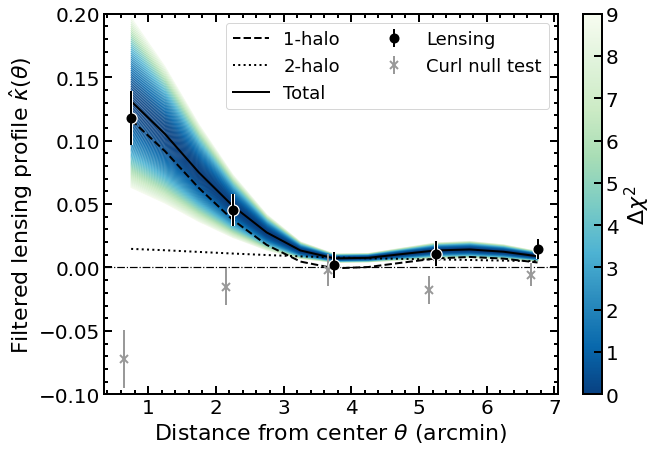

In [56]:
fig, ax = plt.subplots(figsize=(9,7))
# sorting by dchi2 avoids lines with large dchi2 showing up on top of more relevant curves
jsort = np.argsort(-dchi2)
# define colors according to Delta_chi2
range99 = (dchi2[jsort] <= 9)
colors, cmap = colorscale(array=dchi2[jsort][range99], cmap='GnBu_r', vmin=0, vmax=9, )
for k, color in zip(kappa_filt_fine_mean[jsort][range99], colors):
    ax.plot(x_theta_fine, k, '-', color=color, lw=1, zorder=-10)
cbar = plt.colorbar(cmap, label=r'$\Delta\chi^2$', fraction=0.045)
cbar.ax.set_ylim(0,9)
cbar.set_ticks(range(10))
cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())
# plot data points
ax.errorbar(x_theta[:max_bin], kappa_measured[:max_bin], kappa_err[:max_bin],
            fmt='wo', ms=9.5, elinewidth=4., mew=3, zorder=8)
ax.errorbar(x_theta[:max_bin], kappa_measured[:max_bin], kappa_err[:max_bin],
            fmt='ko', ms=8, elinewidth=2, mew=2, zorder=10, label='Lensing')
ax.errorbar(xcurl[:max_bin]-0.1, curl[:max_bin], curl_err[:max_bin],
            fmt='x', color='0.6', mew=2, ms=8, zorder=8, label='Curl null test')
# best-fit model
ax.plot(x_theta_fine, kappa_1h_filt_fine_mean[jbest],
        ls='--', color='k', label='1-halo', zorder=-1)
ax.plot(x_theta_fine, kappa_2h_filt_fine_mean[jbest],
        ls=':', color='k', label='2-halo', zorder=-1)
ax.plot(x_theta_fine, kappa_filt_fine_mean[jbest],
        '-', color='k', label='Total', zorder=-1)
# beautify
ax.legend(loc='upper right', ncol=2)
ax.axhline(0, ls='-.', lw=1.2, color='k')
ax.set_ylim(-0.1, 0.2)
ax.set_xlabel(r'Distance from center $\theta$ (arcmin)')
ax.set_ylabel(r'Filtered lensing profile $\hat\kappa(\theta)$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
fig.savefig('../fig3a.pdf',bbox_inches='tight')

This is the top panel of Figure 3

## Best-fit parameters

In [57]:
bbest, (berr_lo, berr_hi) = bestfit(beta, chi2, 'beta')
mbest, (merr_lo, merr_hi) = bestfit(m_avg, chi2, f'm{delta}{ref_density[0]}',
                                    print_norm=1e14, print_snr=True)
cbest, (cerr_lo, cerr_hi) = bestfit(c_avg, chi2, f'c{delta}{ref_density[0]}')
obest, (oerr_lo, oerr_hi) = bestfit(o_avg, chi2, '<lambda>')
print(f'min(chi2) = {chi2.min():.2f}, PTE={pte:.2f}')

beta: 2.4 -0.3 +0.4
m500c: 1.7 -0.4 +0.4 (SNR=4.2)
c500c: 2.5 -0.0 +0.0
<lambda>: 33.6 -1.5 +1.9
min(chi2) = 1.35, PTE=0.93


For reference, this how the $\chi^2$ depends on the mean mass of the (parent) sample:

(0.0, 25.0)

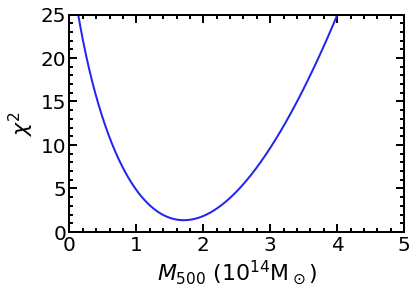

In [58]:
plt.plot(m_avg/1e14, chi2)
plt.xlabel(r'$M_{500}$ ($10^{14}$M$_\odot$)')
plt.ylabel(r'$\chi^2$')
plt.xlim(0, 5)
plt.ylim(0, 25)

# $M_{200}$

To calculate the best-fit $M_{200}$, we just need to convert $M_{500}$ to $M_{200}$ at every point in the grid. We do this with the ``mdelta`` method of our ``NFW`` object:

In [59]:
%%time
m200, c200 = nfw.mdelta(200, background='c')

CPU times: user 14.9 ms, sys: 57 µs, total: 15 ms
Wall time: 14.3 ms


We also need to use the halo mass function calculated at the appropriate overdensity. Note that the same $M_{500}$ at different redshifts will give different $M_{200}$, so the $M_{200}$ array has an extra dimension, corresponding to redshift:

In [60]:
m.shape, m200.shape, z.shape

((31,), (12, 31), (12, 1))

which means we need to loop over mass as well as redshift below:

In [61]:
m200def = ccl.halos.MassDef(200, 'critical')
hmf_ccl_def_m200 = ccl.halos.MassFuncTinker10(cclcosmo, m200def)
dndlog10m200 = np.array([hmf_ccl_def_m200.get_mass_function(cclcosmo, m200_i, 1/(1+zi))
                         for zi, m200_i in zip(z[:,0], m200)])
dndlnm200 = np.log(10) * dndlog10m200

Note that the signal will be the same so we do not need to convert the 2-halo term. We can now calculate the integrals over $M_{500}$ just like we did for $M_{200}$:

In [62]:
m200int_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs * m200[:,:,None], lnobs) for P_lnobs_i in P_lnobs])
m200int_m = trapz(dndlnm200*m200int_obs, np.log(m200), axis=-1)

The expected number of clusters (to normalize the integral):

In [63]:
norm200int_obs = np.array([trapz(obs * P_lnobs_i * S_lnobs, lnobs) for P_lnobs_i in P_lnobs])
norm200int_m = trapz(dndlnm200*norm200int_obs, np.log(m200), axis=-1)

In [64]:
m200_avg = trapz(Ncl_z * m200int_m, z[:,0]) / trapz(Ncl_z * norm200int_m, z[:,0])

(0.0, 25.0)

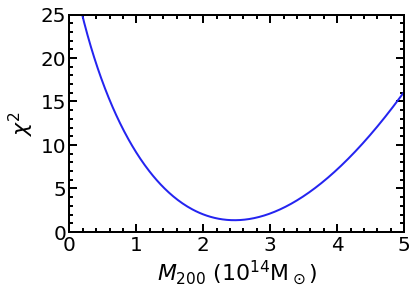

In [65]:
plt.plot(m200_avg/1e14, chi2)
plt.xlabel(r'$M_{200}$ ($10^{14}$M$_\odot$)')
plt.ylabel(r'$\chi^2$')
plt.xlim(0, 5)
plt.ylim(0, 25)

The mean $M_{200}$ is

In [66]:
mbest, (merr_lo, merr_hi) = bestfit(
    m200_avg, chi2, 'm200c', print_norm=1e14, print_snr=True)

m200c: 2.5 -0.6 +0.6 (SNR=4.2)
